In [10]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


import pickle
import pandas as pd

pd.options.display.max_rows = 35 
pd.options.display.max_columns = None

In [2]:
def get_pickles(): 
    x_train = pickle.load(open(f'../../data/processed/pickles/x_train.p', 'rb'))
    x_test = pickle.load(open(f'../../data/processed/pickles/x_test.p', 'rb'))
    y_train = pickle.load(open(f'../../data/processed/pickles/y_train.p', 'rb'))
    y_test = pickle.load(open(f'../../data/processed/pickles/y_test.p', 'rb'))
    X = pickle.load(open('../../data/processed/pickles/X.p', 'rb'))
    y = pickle.load(open('../../data/processed/pickles/y.p', 'rb'))

    return (x_train, x_test, y_train, y_test), (X,y)

(x_train, x_test, y_train, y_test), (X,y) = get_pickles()

print(f'Original X: {X.shape}\tOriginal y: {y.shape}')
print(f'Train X: {x_train.shape}\tTrain y: {y_train.shape}')
print(f'Test X: {x_test.shape}\tTest y: {y_test.shape}')
print(y_train.target.value_counts())
y_train = y_train.target.values.ravel()
y_test = y_test.target.values.ravel()
y = y.target.values.ravel()

standard = StandardScaler() 
x_train[['amount_tsh', 'gps_height', 
         'population', 'time_passed']] = standard.fit_transform(x_train[['amount_tsh', 
                                                                         'gps_height', 'population', 'time_passed']])

Original X: (57247, 53)	Original y: (57247, 1)
Train X: (38090, 53)	Train y: (38090, 1)
Test X: (8588, 53)	Test y: (8588, 1)
1    21545
0    16545
Name: target, dtype: int64


In [ ]:
len(x_train) + len(x_test)

In [40]:


models = {
  'dt': DecisionTreeClassifier(), 
          'rf': RandomForestClassifier(),
        }
#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model

# #test each model and stacking
# results = []
# model_names = []
# pbar = tqdm(models.items())
# for model, m in pbar: 
#     pbar.set_description(f'Evaluating {model.upper()}')
#     cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5)
#     scores = cross_val_score(m, x_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = 14, 
#                              error_score = 'raise')
#     results.append(scores)
#     model_names.append(model)


stack_model
stack_model.fit(x_train, y_train) 
print('Train', stack_model.score(x_train, y_train))
print('Test', stack_model.score(x_test, y_test))

Train 0.9298766080336046
Test 0.637750349324639


In [8]:
from mlxtend.classifier import StackingCVClassifier

classifiers = [DecisionTreeClassifier(), RandomForestClassifier()]
sclf = StackingCVClassifier(classifiers = classifiers, meta_classifier = LogisticRegression(), random_state = 10)

params = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__splitter': ['best', 'random'],
    'decisiontreeclassifier__max_depth': [None, 125, 500, 1000],
    'decisiontreeclassifier__min_samples_split': [8, 10, 15],
    'decisiontreeclassifier__min_samples_leaf': [3, 5, 10], 
    'decisiontreeclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'decisiontreeclassifier__max_leaf_nodes': [None, 25,  50],
    
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__max_depth': [None, 50, 100, 150, 200],
    'randomforestclassifier__min_samples_split': [8,10, 15],
    'randomforestclassifier__min_samples_leaf': [3, 5, 10],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_leaf_nodes': [None, 25, 50], 
    'randomforestclassifier__bootstrap': [False, True],
    
#     'baggingclassifier__n_estimators': [10, 5], 
#     'baggingclassifier__bootstrap': [True, False],
#     'baggingclassifier__bootstrap_features': [True, False],

    
    'meta_classifier__C': [.1, .5, 1, 1.25, 1.5, 2], 
    'meta_classifier__max_iter': [100, 1000,2000],
    'meta_classifier__penalty': ['l1', 'l2'],
    'meta_classifier__solver': ['sag', 'saga', 'liblinear', 'lbfgs', 'newton-cg'],
    'meta_classifier__multi_class': ['ovr', 'multinomial']  
    
    
}
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5)
gs = RandomizedSearchCV(estimator = sclf, param_distributions = params, cv = cv, n_jobs = 8, verbose = 2, n_iter = 20)
gs.fit(x_train,y_train)

Fitting 25 folds for each of 20 candidates, totalling 500 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:   20.9s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:  6.6min finished


RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=None),
                   estimator=StackingCVClassifier(classifiers=[DecisionTreeClassifier(),
                                                               RandomForestClassifier()],
                                                  meta_classifier=LogisticRegression(),
                                                  random_state=10),
                   n_iter=20, n_jobs=8,
                   param_distributions={'decisiontreeclassifier__criterion': ['gini',
                                                                              'entropy'],
                                        'decisiontreeclass...
                                                                              True],
                                        'randomforestclassifier__criterion': ['gini',
                                                                              'entropy'],
                                   

In [9]:
pickle.dump(gs, open('../../models/Stacked_GridSearch.p', 'wb'))
gs.best_estimator_

StackingCVClassifier(classifiers=[DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=125,
                                                         max_features='log2',
                                                         max_leaf_nodes=50,
                                                         min_samples_leaf=10,
                                                         min_samples_split=8),
                                  RandomForestClassifier(max_depth=50,
                                                         min_samples_leaf=3,
                                                         min_samples_split=10)],
                     meta_classifier=LogisticRegression(C=2, max_iter=2000,
                                                        multi_class='ovr',
                                                        solver='liblinear'),
                     random_state=10)

[('dt', DecisionTreeClassifier(criterion='entropy', max_depth=125, max_features='log2',
                       max_leaf_nodes=50, min_samples_leaf=5,
                       min_samples_split=10)), ('Bagging', BaggingClassifier()), ('rf', RandomForestClassifier(bootstrap=False, max_depth=150, max_features='log2',
                       min_samples_leaf=3, min_samples_split=10))]
Train 0.9034654765030191
Test 0.6440381928272008


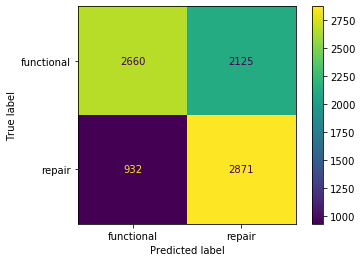

In [7]:
#TUNED STACKED

models = {
          'dt': DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=125,
                                                         max_features='log2',
                                                         max_leaf_nodes=50,
                                                         min_samples_leaf=5,
                                                         min_samples_split=10), 
          
          'rf':RandomForestClassifier(bootstrap=False,
                                                         max_depth=150,
                                                         max_features='log2',
                                                         min_samples_leaf=3,
                                                         min_samples_split=10),
        }
stack_m = [(i,y) for i,y in models.items()]
print(stack_m)

stack_tuned =  StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(C=1,
                                                        multi_class='multinomial',
                                                        solver='saga'), cv = 5)
stack_tuned.fit(x_train, y_train) 
print('Train', stack_tuned.score(x_train, y_train))
print('Test', stack_tuned.score(x_test, y_test))

cm_tuned = plot_confusion_matrix(estimator = stack_tuned, X = x_test, y_true = y_test, 
                                display_labels = ['functional', 'repair'])

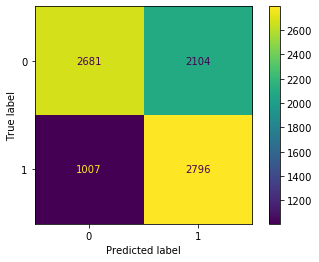

In [41]:
plot_confusion_matrix(stack_model, x_test, y_test)

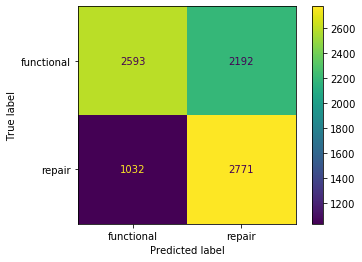

In [36]:
plot_confusion_matrix(estimator = stack_model, X = x_test, y_true = y_test, values_format = 'd', 
                      display_labels = ['functional', 'repair'])

In [ ]:

rf = RandomForestClassifier()
rf.fit(x_train, y_train)
rf.score(x_test, y_test)
plot_confusion_matrix(estimator = rf, X = x_test, y_true = y_test, values_format = 'd', 
                     display_labels = ['functional', 'repair'])

In [ ]:

param_grid = {
     'criterion': ['gini', 'entropy'],
    'max_depth': [None, 50, 100, 150, 200],
    'min_samples_split': [8,10, 15],
    'min_samples_leaf': [3, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 25, 50], 
}
rf = RandomForestClassifier()


cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5)
gs = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = cv, n_jobs = 13, verbose = 2)

gs.fit(x_train, y_train)

In [ ]:
gs.best_estimator_

In [ ]:
rf_tuned = RandomForestClassifier(max_depth=150, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=10)
rf_tuned.fit(x_train, y_train)
plot_confusion_matrix(rf_tuned, x_test, y_test)